NOTEBOOOK DE CRAETION DES ORIGINE DESTINATION LAPI

In [6]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IMPORT DONNEES GLOBALES (SUPPRESSION DES DOUBLONS EN MM TEMPS)

In [3]:
%%time 
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])
df_3semaines=df_3semaines.set_index('created').sort_index()

Wall time: 1min 33s


VERIFICATION DES DONNEES

In [ ]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]

In [27]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

#!!!!!!! ATTENTION : PAS DE TRAITEMENTS EFFECTUES POUR CES ERREURS POUR LE MOMENT !
#propositions : supprimer 1 des 2 occurences pour les docblons
#supprmer les plques mal lues.


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

LISTE DES TRAJETS

In [ ]:
#OLD
liste_trajet_locale=(pd.DataFrame([{'origine':'A63','destination':'A10','cam_o':15, 'cam_d':11, 'trajets':[
                                                        {'cameras':[15,19,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,11],'type_trajet':'indirect'},
                                                        {'cameras':[15,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A63','cam_o':12, 'cam_d':13,'trajets':[{'cameras':[12,6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'N10','cam_o':15, 'cam_d':5,'trajets':[{'cameras':[15,19,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,5],'type_trajet':'indirect'}, 
                                                        {'cameras':[15,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A63','cam_o':6, 'cam_d':13,'trajets':[{'cameras':[6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A10','cam_o':10, 'cam_d':11,'trajets':[{'cameras':[10,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A62','cam_o':12, 'cam_d':9,'trajets':[{'cameras':[12,6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'N10','cam_o':10, 'cam_d':5,'trajets':[{'cameras':[10,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[10,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A62','cam_o':6, 'cam_d':9,'trajets':[{'cameras':[6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[6,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A62','cam_o':15, 'cam_d':9,'trajets':[{'cameras':[15,19,9],'type_trajet':'indirect'},
                                                        {'cameras':[15,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A63','cam_o':10, 'cam_d':13,'trajets':[{'cameras':[10,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[10,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A63','cam_o':8 ,'cam_d':13,'trajets':[{'cameras':[8,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,13],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A89','cam_o':15, 'cam_d':7,'trajets':[{'cameras':[15,19,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,19,7],'type_trajet':'indirect'},
                                                        {'cameras':[15,7],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A62','cam_o':8, 'cam_d':9,'trajets':[{'cameras':[8,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[8,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'A89','cam_o':10, 'cam_d':7,'trajets':[{'cameras':[10,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[10,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'A10','cam_o':8, 'cam_d':11,'trajets':[{'cameras':[8,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[8,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A89','cam_o':12, 'cam_d':7,'trajets':[{'cameras':[12,6,7],'type_trajet':'indirect'},
                                                        {'cameras':[12,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'N10','cam_o':8, 'cam_d':5,'trajets':[{'cameras':[8,5],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'N10','destination':'A89','cam_o':6, 'cam_d':7,'trajets':[{'cameras':[6,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A660','cam_o':12, 'cam_d':18,'trajets':[{'cameras':[12,6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A660','destination':'A10','cam_o':19, 'cam_d':18,'trajets':[{'cameras':[19,4,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,11],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A660','destination':'A62','cam_o':19, 'cam_d':9,'trajets':[{'cameras':[19,9],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A62','destination':'A660','cam_o':10, 'cam_d':18,'trajets':[{'cameras':[10,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A660','destination':'A89','cam_o':19, 'cam_d':7,'trajets':[{'cameras':[19,4,7],'type_trajet':'indirect'},
                                                         {'cameras':[19,7],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A89','destination':'A660','cam_o':8, 'cam_d':18,'trajets':[{'cameras':[8,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[8,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'N10','destination':'A660','cam_o':6, 'cam_d':18,'trajets':[{'cameras':[6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A660','destination':'N10','cam_o':19, 'cam_d':5,'trajets':[{'cameras':[19,1,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,5],'type_trajet':'direct'},
                                                        ]}
                           ]))[['origine', 'destination', 'cam_o', 'cam_d','trajets']]
liste_trajet_locale.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\OLD_liste_trajets.json',orient='records')

liste_complete_trajet=pd.DataFrame([[tuple(liste_cam['cameras']),value[0],value[1],value[2],value[3],len(liste_cam['cameras'])] for obj, value in liste_trajet_locale.iterrows() for liste_cam in value[4]],
             columns=['cameras','origine','destination','cam_o','cam_d','nb_cams'])
liste_complete_trajet=liste_complete_trajet.sort_values('nb_cams',ascending=False)
liste_complete_trajet.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\trajets_possibles.json',orient='index')
liste_complete_trajet

In [154]:
liste_complete_trajet=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [155]:
liste_complete_trajet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,11,15,"(15, 19, 4, 5, 11)",A10,120.325213,5,A63-A10,A63,01:30:14.634000
1,11,15,"(15, 19, 1, 5, 11)",A10,125.202188,5,A63-A10,A63,01:33:54.098000
13,13,12,"(12, 6, 3, 18, 13)",A63,105.139253,5,A10-A63,A10,01:18:51.266000
12,13,12,"(12, 6, 2, 18, 13)",A63,108.707013,5,A10-A63,A10,01:21:31.815000
56,7,15,"(15, 19, 4, 7)",A89,90.709158,4,A63-A89,A63,01:08:01.912000
36,11,10,"(10, 4, 5, 11)",A10,64.969553,4,A62-A10,A62,00:48:43.629000
31,13,6,"(6, 3, 18, 13)",A63,85.355597,4,N10-A63,N10,01:04:01.001000
25,5,15,"(15, 19, 1, 5)",N10,89.925738,4,A63-N10,A63,01:07:26.658000
24,5,15,"(15, 19, 4, 5)",N10,85.048763,4,A63-N10,A63,01:03:47.194000
30,13,6,"(6, 2, 18, 13)",A63,88.923357,4,N10-A63,N10,01:06:41.551000


TESTS DONNEES COMPLETES

In [139]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-28 00:00:00',1,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-04-17 15:23:36.015909
date : 2019-01-28 01:00:00 debut_traitement : 2019-04-17 15:23:36.846558
date : 2019-01-28 02:00:00 debut_traitement : 2019-04-17 15:23:37.518289
date : 2019-01-28 03:00:00 debut_traitement : 2019-04-17 15:23:38.252484
date : 2019-01-28 04:00:00 debut_traitement : 2019-04-17 15:23:38.955473
date : 2019-01-28 05:00:00 debut_traitement : 2019-04-17 15:23:40.048972
date : 2019-01-28 06:00:00 debut_traitement : 2019-04-17 15:23:41.657970
date : 2019-01-28 07:00:00 debut_traitement : 2019-04-17 15:23:43.673126
date : 2019-01-28 08:00:00 debut_traitement : 2019-04-17 15:23:46.094439
date : 2019-01-28 09:00:00 debut_traitement : 2019-04-17 15:23:49.265590
date : 2019-01-28 10:00:00 debut_traitement : 2019-04-17 15:23:52.608520
date : 2019-01-28 11:00:00 debut_traitement : 2019-04-17 15:23:55.795281
date : 2019-01-28 12:00:00 debut_traitement : 2019-04-17 15:23:58.888344
date : 2019-01-28 13:00:00 debut_traitement : 2019-

IMPORTANT : VERIF DES DOUBLONS ENTRE LES TRAJETS

In [830]:
df_depart=dico_od.loc[dico_od['destination']=='A89'].copy()
jointure=df_depart.merge(dico_od, on='immat')
jointure=jointure.loc[jointure.date_cam_1_x!=jointure.date_cam_1_y].copy()
(jointure.loc[((jointure.date_cam_1_y>=jointure.date_cam_1_x) & (jointure.date_cam_1_y<=jointure.date_cam_2_x)) |
              ((jointure.date_cam_2_y>=jointure.date_cam_1_x) & (jointure.date_cam_2_y<=jointure.date_cam_2_x))])

DATAFRAME DES TEMPS DE PARCOURS MAX AVEC LE TYPE

In [144]:
dico_tps_max.loc[(dico_tps_max['o_d']=='A660-N10')]

,date,temps,type,o_d,cameras
0,2019-01-28 00:00:00,09:40:39,85eme_percentile,A660-N10,"(19, 4, 5)"
0,2019-01-28 02:00:00,01:55:16,85eme_percentile,A660-N10,"(19, 5)"
0,2019-01-28 06:00:00,02:04:08.250000,85eme_percentile,A660-N10,"(19, 4, 5)"
0,2019-01-28 07:00:00,00:51:56,Cluster,A660-N10,"(19, 4, 5)"
7,2019-01-28 07:00:00,00:47:07.100000,85eme_percentile,A660-N10,"(19, 5)"
4,2019-01-28 08:00:00,00:39:49,Cluster,A660-N10,"(19, 4, 5)"
5,2019-01-28 08:00:00,02:25:15.750000,85eme_percentile,A660-N10,"(19, 5)"
10,2019-01-28 08:00:00,00:40:03.700000,85eme_percentile,A660-N10,"(19, 1, 5)"
1,2019-01-28 09:00:00,00:31:39.150000,85eme_percentile,A660-N10,"(19, 5)"
3,2019-01-28 09:00:00,00:35:48,Cluster,A660-N10,"(19, 4, 5)"


CREER LE TABLEAU DE MATRICE O-D

In [140]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NaN,392.0,262.0,189.0,48.0,NaN,891
A62,179.0,NaN,55.0,107.0,56.0,216.0,613
A63,540.0,31.0,NaN,NaN,155.0,2555.0,3281
A660,179.0,79.0,NaN,NaN,117.0,423.0,798
A89,49.0,136.0,199.0,176.0,NaN,130.0,690
N10,NaN,294.0,841.0,315.0,63.0,NaN,1513
All,947.0,932.0,1357.0,787.0,439.0,3324.0,7786


POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

In [ ]:
pct_pl=t.pourcentage_pl_camera('2019-01-28 00:00:00', 1,df_3semaines.reset_index(),dico_passag)
pct_pl

VERIFICATION

In [30]:
# #retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='fffbb020a440bbec286fc41d4b70865e990b4bb7']

,camera_id,immat,fiability,l,state
created,,,,,
2019-02-10 09:38:43,4,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,1,FR
2019-02-10 09:49:02,5,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,1,FR
2019-02-10 09:50:56,10,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,1,FR
2019-02-10 10:07:29,11,fffbb020a440bbec286fc41d4b70865e990b4bb7,99,0,FR


In [865]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='2da9c14f66a652882b65149a257de9f25f5a5a24']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours


In [136]:
#verif a un horaire donne sur un trajet direct ou indirect
%time test=t.trajet(df_3semaines.loc['2019-01-28 00:00:00':'2019-01-29 23:59:59'], '2019-01-28 08:00:00', 60, [19, 5],typeTrajet='Global')

Wall time: 594 ms


liste des o-d :['A63-A10' 'A63-N10' 'A63-A89' 'A660-A89' 'A660-A10' 'A660-N10' 'A660-A62'
 'A63-A62']


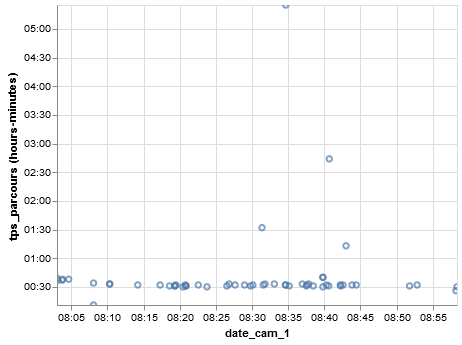

In [138]:
test.graph()['A660-N10']

TESTS A LA MANO

In [135]:
#pour test des fonctions de trajets directs
df_duree=df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'].loc['2019-01-29 21:00:00':'2019-01-29 22:00:00']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==19]
df_duree_autres_cam=df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'].loc[(df_3semaines.loc['2019-01-29 21:00:00':'2019-01-30 15:00:00'].loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
cam1_croise_autre_cam=df_duree_cam1.reset_index().merge(df_duree_autres_cam.reset_index(), on='immat')
cam1_croise_suivant=cam1_croise_autre_cam.loc[(cam1_croise_autre_cam.loc[:,'created_x']<cam1_croise_autre_cam.loc[:,'created_y'])]
cam1_fastest_next=cam1_croise_suivant.loc[cam1_croise_suivant.groupby(['immat'])['created_y'].idxmin()]

In [810]:
%%time
#pour test des fonctions de trajets global 
camera1, camera2=10,18
df=df_3semaines.loc['2019-01-28 10:00:00':'2019-01-29 23:59:59']
df_duree=df.loc['2019-01-28 10:00:00':'2019-01-28 11:00:00']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
df_duree_autres_cam=df.loc[(df.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),'1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)
df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','state','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]

df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state']].rename(columns={'l_y':'l'}))

Wall time: 344 ms


In [785]:
def filtrer_passage(liste, df_liste_trajet, cam) :
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

In [3]:
def recuperer_date_cam2(liste,liste_created,df_liste_trajet, cam):
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]

TESTS

In [6]:
# illsutration de la fibilité des cameras
df_3semaines.groupby('camera_id')['fiability'].mean()

camera_id
1     44.025346
2     45.053603
3     88.447345
4     84.762897
5     89.014911
6     88.729116
7     89.318629
8     88.783314
9     84.869740
10    87.667409
11    88.111139
12    88.565236
13    91.133875
15    91.244692
18    87.460676
19    87.803266
Name: fiability, dtype: float64

In [113]:
#jointure dico_od et dico_tps_max
#tata=dico_od.merge(dico_tps_max, on='o_d' )
for date in pd.date_range('2019-01-28 00:00:00', periods=2, freq='H') : 
    print(pd.to_datetime('2019-01-28 00:30:00').to_period(pd.Period(date,freq='H').freq)==(pd.Period(date,freq='H')))

True
False


In [8]:
fichier_dist=gpd.read_file(r'D:\temp\lapi\itineraire.shp')

In [42]:
fichier_dist.head(1)

,gid,origin,destin,lapi_o,lapi_d,long_km,geometry
0,1.0,119,117,19,18,22.493024,"(LINESTRING (402136.2093203766 6406986.729732256, 402080.1999999995 6406922.299999989, 402004.2999999996 6406838.09999999, 401928.9999999996 6406758.29999999, 401793.8999999997 6406621.09999999, 401699.4999999995 6406530.599999988, 401575.4999999995 6406417.09999999, 401499.1999999996 6406350.899999991, 401476.7999999996 6406331.39999999, 401376.3999999996 6406247.89999999, 401264.9999999995 6406159.099999988, 401232.5999999995 6406134.499999989, 401177.4999999996 6406093.099999989, 401125.7999999996 6406054.899999991, 401053.8999999996 6406003.19999999, 400985.0999999996 6405954.799999989, 400918.1999999995 6405909.399999989, 400856.2999999995 6405867.599999988, 400806.7999999996 6405835.59999999, 400741.4999999997 6405793.89999999, 400665.7999999996 6405745.39999999, 400583.1999999995 6405693.999999989, 400512.0999999996 6405650.599999989, 400433.5999999995 6405602.299999989, 400341.1999999997 6405546.199999991, 400216.1999999996 6405470.499999989, 400065.6999999995 6405379.69999..."


In [91]:
test_compare=dico_tps_max.merge(liste_complete_trajet, on='cameras')
test_compare.loc[(test_compare['type']=='Cluster') & (pd.Period(test_compare['date'], freq='4H')>pd.Period('2019-01-28 06:00:00',freq='4H'))]

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [62]:
liste_complete_trajet.sort_values('o_d').to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\trajets_possibles.json', orient='index')

In [57]:
pd.Timedelta(hours=1.35)

Timedelta('0 days 01:21:00')